# Détection des lignes d'un terrain de foot

#### Importation des librairies nécessaires

In [51]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # La croissance de la mémoire doit être définie avant l'initialisation des GPU
        print(e)
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2


### Création d'un model type Unet

Plusieurs types de models ont été testés et comparés la seule variable étant le nombre de neuronnes par couche. L'objectif étant de trouver pour une même architecture, le nombre optimal de neuronnes entre précision et rapidité.

In [73]:
power_mul = 3

def conv_block(input_tensor, num_filters):
    tensor = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    tensor = tf.keras.layers.Activation('relu')(tensor)
    tensor = Conv2D(num_filters, (3, 3), padding='same')(tensor)
    tensor = tf.keras.layers.Activation('relu')(tensor)
    tensor = Dropout(0.2)(tensor)
    return tensor

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, 2**(0+power_mul))
    x2, p2 = encoder_block(p1, 2**(1+power_mul))
    x3, p3 = encoder_block(p2, 2**(2+power_mul))
    x4, p4 = encoder_block(p3, 2**(3+power_mul))

    # Pont
    b = conv_block(p4, 2**(4+power_mul))

    # Decoder
    d1 = decoder_block(b, x4, 2**(3+power_mul))
    d2 = decoder_block(d1, x3, 2**(2+power_mul))
    d3 = decoder_block(d2, x2, 2**(1+power_mul))
    d4 = decoder_block(d3, x1, 2**(0+power_mul))

    # Output
    if num_classes == 1:  # Seuillage binaire
        activation = 'sigmoid'
    else:  # Seuillage multiclasse
        activation = 'softmax'

    outputs = Conv2D(num_classes, (1, 1), activation=activation)(d4)

    model = Model(inputs, outputs)
    return model


def dice_metric(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    
    return (numerator + 1) / (denominator + 1)

def combined_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + 0.5 * (1 - dice_metric(y_true, y_pred))


# Build du model
input_shape = (448, 768, 3)  # Le model fonctionne mieux avec des images dont la taille est un multiple de 2^4 et/ou 2^5
num_classes = 1
model = build_unet(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy', dice_metric])

# Model summary
model.summary()

# model total parameters
total_params = model.count_params()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 448, 768, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 448, 768, 8)          224       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 448, 768, 8)          0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 448, 768, 8)          584       ['activation[0][0]']          
                                                                                              

### Préparation des données

On souhaite charger tout les masques et toutes les images correspondantes.
On vérifie donc que chaque image à un masque associé et on redimensionne tout.
L'augmentation des données est réalisé par tensorflow et multiplie les données par la variable `nb_mul`

In [86]:
nb_mul = 5

def resize_images(dataset, new_size=(448, 768)):
    resized_dataset = []
    for image in dataset:
        resized_image = tf.image.resize(image, new_size)
        resized_dataset.append(resized_image)
    return np.array(resized_dataset)

def create_extended_dataset(images, masks, augment=True, batch_size=32):
    global nb_mul
    # Définition des paramètres de l'augmentation
    data_gen_args = dict(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Creation du générateur aléatoire
    if augment:
        image_datagen = ImageDataGenerator(**data_gen_args)
        mask_datagen = ImageDataGenerator(**data_gen_args)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    
    seed = 1
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed, shuffle=False)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed, shuffle=False)
    
    augmented_images = []
    augmented_masks = []

    # Iteration pour générer les images augmentées
    for _ in range(nb_mul*(len(images) // batch_size)):
        img_batch, mask_batch = next(image_generator), next(mask_generator)
        augmented_images.extend(img_batch)
        augmented_masks.extend(mask_batch)

    # Concaténation des images augmentées avec les images originales
    combined_images = np.concatenate([images, np.array(augmented_images)], axis=0)
    combined_masks = np.concatenate([masks, np.array(augmented_masks)], axis=0)

    return combined_images, combined_masks



def load_images_from_folder(mask_folder, img_folder):
    masks = []
    images = []
    for filename in os.listdir(mask_folder):
        m = load_img(os.path.join(mask_folder,filename), color_mode='grayscale')
        m = img_to_array(m)
        try:
            i = load_img(os.path.join(img_folder, filename), color_mode='rgb')
            i = img_to_array(i)

        except FileNotFoundError:
            print("The specified file does not exist.")
        if i is not None and m is not None:
            masks.append(m)
            images.append(i)

    return masks, images

def load_data(type_label):
    # Chargement masque pour ligne
    mask_dir = "./labels_"+type_label
    img_dir = "./videos"

    masks, images = load_images_from_folder(mask_dir+"/log1", img_dir+"/log1")

    logaddm, logaddi = load_images_from_folder(mask_dir+"/log2", img_dir+"/log2")
    masks += logaddm
    images += logaddi

    logaddm, logaddi = load_images_from_folder(mask_dir+"/log3", img_dir+"/log3")
    masks += logaddm
    images += logaddi

    logaddm, logaddi = load_images_from_folder(mask_dir+"/log4", img_dir+"/log4")
    masks += logaddm
    images += logaddi

    images = np.array(images, dtype="float32")
    masks = np.array(masks, dtype="float32")

    # Normalization des images et des masques pour avoir des valeurs entre 0 et 1
    images /= 255.0
    masks /= 255.0

    return images, masks


# Type de données à charger : line / terrain
type_label = "line"


# Chargement des données
# Si les données n'ont pas déjà été sauvegardées, on les charge et on les sauvegarde
if not os.path.isfile("dataset/X_train_"+type_label+"_"+str(nb_mul)+".npy"):
    images, masks = load_data(type_label)
    # Resize images and masks
    images = resize_images(images)
    masks = resize_images(masks)

    # Augment the data
    images, masks = create_extended_dataset(images, masks, augment=True, batch_size=33)
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

    
    # Check the shape of the loaded data
    X_train.shape, y_train.shape, X_val.shape, y_val.shape

    #save X and y
    np.save("dataset/X_train_"+type_label+"_"+str(nb_mul), X_train)
    np.save("dataset/y_train_"+type_label+"_"+str(nb_mul), y_train)
    np.save("dataset/X_val_"+type_label+"_"+str(nb_mul), X_val)
    np.save("dataset/y_val_"+type_label+"_"+str(nb_mul), y_val)
else:
    X_train = np.load("dataset/X_train_"+type_label+"_"+str(nb_mul)+".npy")
    y_train = np.load("dataset/y_train_"+type_label+"_"+str(nb_mul)+".npy")
    X_val = np.load("dataset/X_val_"+type_label+"_"+str(nb_mul)+".npy")
    y_val = np.load("dataset/y_val_"+type_label+"_"+str(nb_mul)+".npy")



### Entrainement du modèle

On sauvgarde par le biais d'un callback à chaque epoch, les modèles pour lequel la `val_accuracy` et la `val_dice_metric` sont les plus élevée 

In [75]:
tf.keras.backend.clear_session()

tensorboard_callback = TensorBoard(log_dir='./logs/'+type_label+"_"+str(total_params), histogram_freq=1)

checkpoint_acc = ModelCheckpoint(
    'acc_model_'+type_label+'_'+str(total_params)+'_.h5',  # chemin où sauvegarder le modèle
    monitor='val_accuracy',  # métrique à surveiller
    verbose=1,  # afficher des messages détaillés
    save_best_only=True,  # sauvegarder uniquement le meilleur modèle
    mode='max'  # Sauvegarder le modèle avec la meilleure accuracy
)

checkpoint_dice = ModelCheckpoint(
    'dice_model_'+type_label+'_'+str(total_params)+'_.h5',  # chemin où sauvegarder le modèle
    monitor='val_dice_metric',  # métrique à surveiller
    verbose=1,  # afficher des messages détaillés
    save_best_only=True,  # sauvegarder uniquement le meilleur modèle
    mode='max'  # Sauvegarder le modèle avec la meilleure accuracy
)

# Entraînement du modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=2,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint_acc, checkpoint_dice, tensorboard_callback]
)

# Sauvegarde du modèle
model.save('unet.h5')

# free VRAM
import gc
del model
gc.collect()



Epoch 1/20


2023-12-11 12:11:51.234195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


64/64 [==============================] - ETA: 0s - loss: 0.4907 - accuracy: 0.7148 - dice_metric: 0.6587
Epoch 1: val_accuracy improved from -inf to 0.76318, saving model to acc_model_terrain_491137_.h5

Epoch 1: val_dice_metric improved from -inf to 0.85419, saving model to dice_model_terrain_491137_.h5
64/64 [==============================] - 5s 28ms/step - loss: 0.4907 - accuracy: 0.7148 - dice_metric: 0.6587 - val_loss: 0.2368 - val_accuracy: 0.7632 - val_dice_metric: 0.8542
Epoch 2/20
61/64 [===========================>..] - ETA: 0s - loss: 0.2259 - accuracy: 0.8082 - dice_metric: 0.8720
Epoch 2: val_accuracy improved from 0.76318 to 0.92499, saving model to acc_model_terrain_491137_.h5

Epoch 2: val_dice_metric improved from 0.85419 to 0.92165, saving model to dice_model_terrain_491137_.h5
64/64 [==============================] - 2s 24ms/step - loss: 0.2206 - accuracy: 0.8138 - dice_metric: 0.8759 - val_loss: 0.1401 - val_accuracy: 0.9250 - val_dice_metric: 0.9216
Epoch 3/20
64/6

8994

### Traitement pour la méthode du masquage du terrain

1/1 [==============================] - 0s 100ms/step


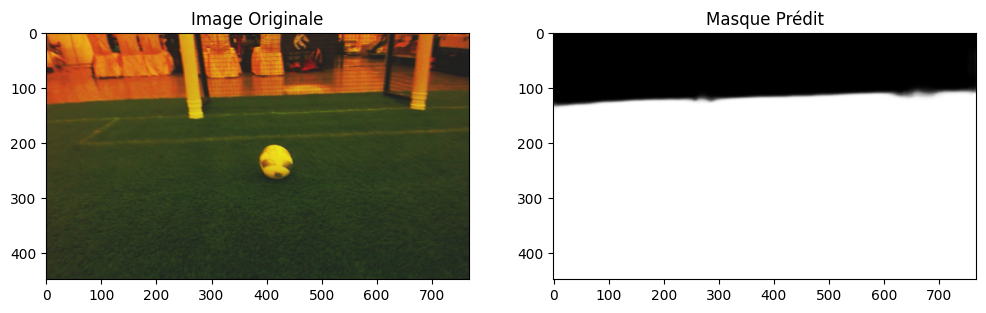

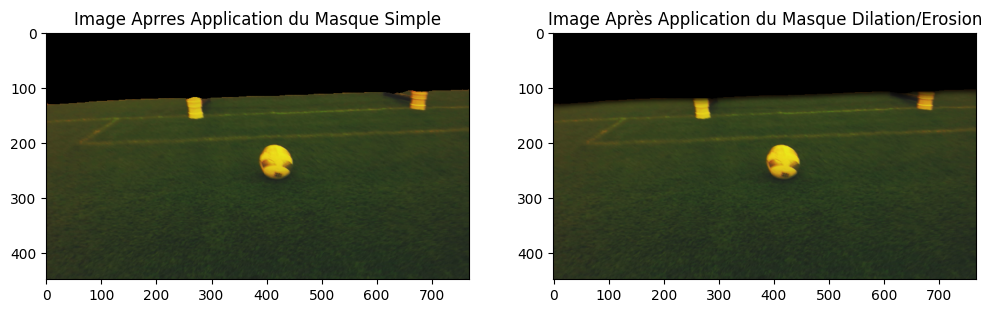

In [89]:
# Charger le modèle
acc_model = tf.keras.models.load_model("acc_model_terrain_"+str(total_params)+"_.h5", custom_objects={'combined_loss': combined_loss, 'dice_metric': dice_metric})
dice_model = tf.keras.models.load_model("dice_model_terrain_"+str(total_params)+"_.h5", custom_objects={'combined_loss': combined_loss, 'dice_metric': dice_metric})

# Charger et préparer l'image
image_path = "videos/log2/038-rgb.png"
image = load_img(image_path, target_size=(448, 768))  # Ajustez la taille selon votre modèle
image = img_to_array(image)
image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour le batch
image = image / 255.0

# Prédire le masque
acc_predicted_mask = acc_model.predict(image)
dice_predicted_mask = dice_model.predict(image)
#deepcopy pour pouvoir modifier le masque sans modifier l'original
acc_unthresholded_mask = np.squeeze(acc_predicted_mask[0, ..., 0]).copy()
dice_unthresholded_mask = np.squeeze(dice_predicted_mask[0, ..., 0]).copy()

# Appliquer le masque à l'image originale (à ajuster selon votre cas d'utilisation)
# Par exemple, masquer l'image là où le masque est supérieur à un seuil
threshold = 0.25

# Convertir le masque prédit pour les opérations morphologiques
acc_mask_for_morphology = np.squeeze(acc_predicted_mask[0, ..., 0])
dice_mask_for_morphology = np.squeeze(dice_predicted_mask[0, ..., 0])

# Add gaussian blur befor morphological operations
acc_mask_for_morphology = cv2.GaussianBlur(acc_mask_for_morphology, (25, 25), 0)
dice_mask_for_morphology = cv2.GaussianBlur(dice_mask_for_morphology, (25, 25), 0)

# Définir un élément structurant pour les opérations morphologiques
kernel = np.ones((20, 20), np.uint8)

# Appliquer l'érosion et la dilatation
acc_eroded_mask = cv2.erode(acc_mask_for_morphology, kernel, iterations=1)
dice_eroded_mask = cv2.erode(dice_mask_for_morphology, kernel, iterations=1)
acc_dilated_mask = cv2.dilate(acc_eroded_mask, kernel, iterations=1)
dice_dilated_mask = cv2.dilate(dice_eroded_mask, kernel, iterations=1)

# Appliquer le seuil après les opérations morphologiques
acc_dilated_mask[acc_dilated_mask > threshold] = 1
dice_dilated_mask[dice_dilated_mask <= threshold] = 0

# Appliquer le masque morphologiquement amélioré à l'image
acc_masked_image_with_morphology = image[0] * np.expand_dims(acc_dilated_mask, axis=-1)
dice_masked_image_with_morphology = image[0] * np.expand_dims(dice_dilated_mask, axis=-1)


# threshold the mask
acc_predicted_mask[acc_predicted_mask > threshold] = 1
dice_predicted_mask[dice_predicted_mask > threshold] = 1
acc_predicted_mask[acc_predicted_mask <= threshold] = 0
dice_predicted_mask[dice_predicted_mask <= threshold] = 0
acc_masked_image = image[0] * acc_predicted_mask[0]
dice_masked_image = image[0] * dice_predicted_mask[0]

# Afficher l'image originale et l'image masquée
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Image Originale")
plt.imshow(image[0])

# afficher predicted_mask
plt.subplot(1, 2, 2)
plt.title("Masque Prédit")
plt.imshow(dice_unthresholded_mask, cmap='gray')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Image Aprres Application du Masque Simple")
plt.imshow(dice_masked_image)



plt.subplot(1, 2, 2)
plt.title("Image Après Application du Masque Dilation/Erosion")
plt.imshow(dice_masked_image_with_morphology)
plt.show()


### Traitement pour la classification directe des lignes

1/1 [==============================] - 0s 93ms/step


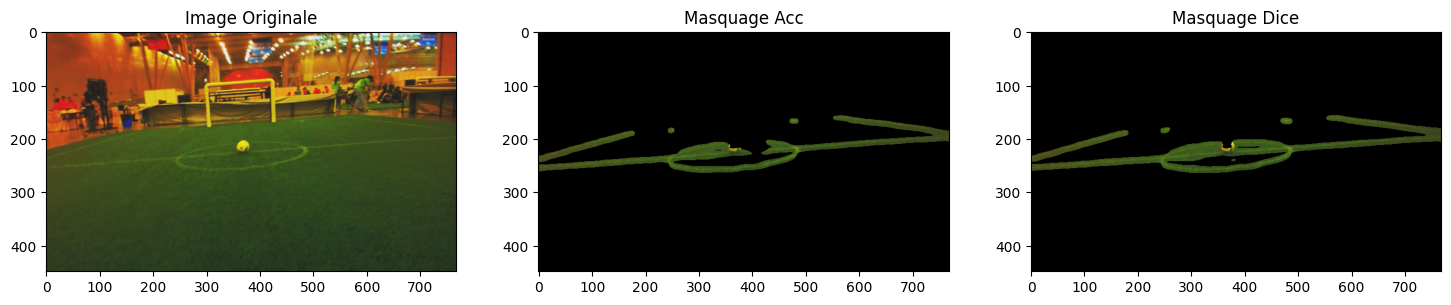

In [56]:
# Charger le modèle
acc_model = tf.keras.models.load_model("acc_model_line_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})
dice_model = tf.keras.models.load_model("dice_model_line_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})

# Charger et préparer l'image
image_path = "videos/log1/039-rgb.png"
image = load_img(image_path, target_size=(448, 768))  # Ajustez la taille selon votre modèle
image = img_to_array(image)
image = np.expand_dims(image, axis=0)  # Ajouter une dimension pour le batch
image = image / 255.0

# Prédire le masque
acc_predicted_mask = acc_model.predict(image)
dice_predicted_mask = dice_model.predict(image)
#deepcopy pour pouvoir modifier le masque sans modifier l'original
acc_unthresholded_mask = np.squeeze(acc_predicted_mask[0, ..., 0]).copy()
dice_unthresholded_mask = np.squeeze(dice_predicted_mask[0, ..., 0]).copy()

# Appliquer le masque à l'image originale (à ajuster selon votre cas d'utilisation)
# Par exemple, masquer l'image là où le masque est supérieur à un seuil
threshold = 0.25

# threshold the mask
acc_predicted_mask[acc_predicted_mask > threshold] = 1
dice_predicted_mask[dice_predicted_mask > threshold] = 1
acc_predicted_mask[acc_predicted_mask <= threshold] = 0
dice_predicted_mask[dice_predicted_mask <= threshold] = 0
acc_masked_image = image[0] * acc_predicted_mask[0]
dice_masked_image = image[0] * dice_predicted_mask[0]

# Afficher l'image originale et l'image masquée
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Image Originale")
plt.imshow(image[0])

# afficher predicted_mask
plt.subplot(1, 3, 2)
plt.title("Masquage Acc")
plt.imshow(acc_masked_image)

plt.subplot(1, 3, 3)
plt.title("Masquage Dice")
plt.imshow(dice_masked_image)
plt.show()

### Traitement Vidéo

In [90]:
# Charger le modèle
model = tf.keras.models.load_model("dice_model_terrain_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})
#model = tf.keras.models.load_model("dice_model_line_"+str(total_params)+"_.h5", custom_objects={'dice_metric': dice_metric, 'combined_loss': combined_loss})


# Ouvrir la vidéo
video_path = 'videos/log1.mp4'
cap = cv2.VideoCapture(video_path)
threshold = 0.6
kernel = np.ones((20, 20), np.uint8)


# Préparer l'enregistrement de la vidéo (si nécessaire)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (768, 448))


# Lire la vidéo frame par frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir en RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Redimensionner et normaliser la frame
    resized_frame = cv2.resize(frame, (768, 448))
    normalized_frame = resized_frame / 255.0
    normalized_frame = np.expand_dims(normalized_frame, axis=0)

    

    # Prédire le masque
    predicted_mask = model.predict(normalized_frame)

    # Appliquer les opérations morphologiques
    mask_for_morphology = np.squeeze(predicted_mask[0, ..., 0])
    # Add gaussian blur befor morphological operations
    """ mask_for_morphology = cv2.GaussianBlur(mask_for_morphology, (25, 25), 0)
    mask_for_morphology = cv2.erode(mask_for_morphology, kernel, iterations=1)
    mask_for_morphology = cv2.dilate(mask_for_morphology, kernel, iterations=1) """
    mask_for_morphology[mask_for_morphology > threshold] = 1
    mask_for_morphology[mask_for_morphology <= threshold] = 0

    # Appliquer le masque à la frame pour que les pixels blancs du masque soient rouges dans la frame
    masked_frame = resized_frame.copy()

    masked_frame[mask_for_morphology == 0] = [0, 0, 0] # terrain
    #masked_frame[mask_for_morphology == 1] = [255, 0, 0] # line

    # Convertir en format BGR pour OpenCV et remettre à l'échelle
    masked_frame = masked_frame.astype('uint8')  # Remettre à l'échelle et convertir en uint8

    # Convertir en BGR
    masked_frame = cv2.cvtColor(masked_frame, cv2.COLOR_RGB2BGR)

    # Afficher la frame masquée (ou enregistrer)
    cv2.imshow('Frame', masked_frame)
    #out.write(masked_frame)

    # Quitter avec 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer les ressources
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 14ms/step
